In [40]:
import numpy as np
from numba import njit

In [75]:
class IsodataClustering:
    '''
    for initial purpose we assume 
    the fit function works only for one image
        - fit only one image
    '''

    class _Cluster:
        '''
        Inner class represent the cluster points and its centroid
        '''

        def __init__(self):
            self.centroid = None
            self.points = []
            self.indexes = []
    
    def __init__(self, num_clusters=2, max_iterations=10, min_samples_in_cluster=3, max_variance=1.0, 
                 merge_threshold=0.9, T = 0.7):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.min_samples_in_cluster = min_samples_in_cluster
        self.max_variance = max_variance
        self.merge_threshold = merge_threshold
        self.centroids = []
        self.T = T
        
    def fit(self, X):
        self.clusters = self._initialize_clusters(X)
        fixed_points_ratio = 0
        total_num_points = X.shape[0] * X.shape[1]
        iteration = 1

        while iteration <= self.max_iterations and fixed_points_ratio < self.T:
            print("{}/{} =======================> In Progress".format(iteration, self.max_iterations), end="")

            changes = 0
            # Assign points to self.clusters
            for cluster_idx, cluster in enumerate(self.clusters):
                for point_idx, point in enumerate(cluster.points):
                    distances = [np.linalg.norm(point - c.centroid) for c in self.clusters]
                    closest_centroid_idx = np.argmin(distances)

                    if closest_centroid_idx != cluster_idx:
                        changes += 1
                        # add the points to the target class
                        self.clusters[closest_centroid_idx].points.append(point)
                        self.clusters[closest_centroid_idx].indexes.append(cluster.indexes[point_idx])

                        # remove the point from the current class
                        cluster.points.pop(point_idx)
                        cluster.indexes.pop(point_idx)

            # calculate the changed points ratio
            fixed_points_ratio = 1 - changes / total_num_points

            # Update centroids
            for cluster in self.clusters:
                cluster.centroid = np.mean(cluster.points)
            
            # Remove empty self.clusters
            self.clusters = [c for c in self.clusters if len(c.points) > 0]
            if len(self.clusters) == 1:
                break
                
            # Check if any self.clusters need to be splitted
            if len(self.clusters) < self.num_clusters:
                largest_cluster_idx = np.argmax([len(c.points) for c in self.clusters])
                largest_cluster = self.clusters[largest_cluster_idx]
                # Check variance of largest cluster
                if np.amax(np.var(largest_cluster.points, axis=0)) > self.max_variance and len(largest_cluster.points) >= 2 * self.min_samples_in_cluster:
                    cluster_1, cluster_2 = self._split_cluster(largest_cluster)
                    self.clusters.pop(largest_cluster_idx)
                    self.clusters.append(cluster_1)
                    self.clusters.append(cluster_2)
            
            # Check if any self.clusters need to be merged
            clusters_size = len(self.clusters)
            cluster_distances = np.full((clusters_size, clusters_size), 1e9)
            for i in range(clusters_size):
                for j in range(i + 1, clusters_size):
                    distance = np.linalg.norm(self.clusters[i].centroid - self.clusters[j].centroid)
                    cluster_distances[i][j] = distance
                    
            min_distance_idx = np.unravel_index(np.argmin(cluster_distances), cluster_distances.shape)
            # todo: try to optimize that later
            if cluster_distances[min_distance_idx] < self.merge_threshold:
                self.clusters[min_distance_idx[0]].points += self.clusters[min_distance_idx[1]].points
                self.clusters[min_distance_idx[0]].indexes += self.clusters[min_distance_idx[1]].indexes
                self.clusters.pop(min_distance_idx[1])

            print(' ✔')
            
            # update iteration
            iteration = iteration + 1
            
        self.labels_ = np.zeros((X.shape[0], X.shape[1]))
        for i, c in enumerate(self.clusters):
            for j in c.indexes:
                self.labels_[j] = i

        for cluster in self.clusters:
            self.centroids.append(cluster.centroid)

        return self
                

    def _initialize_centroids(self, X):
        '''
        Generate the initial centroids, by interpolate 
        equidistant points between first two points 
        generated from the mean and std values of the
        points
        ### Parameters:
            - X: array_ of points `Image`
        ### Returns:
            - `Initial Centriods`
        '''
        mean = np.mean(X, axis=(0, 1))
        std = np.std(X, axis=(0, 1))
        point_1 = np.array([mean - std])
        point_2 = np.array([mean + std])
        return np.linspace(point_1, point_2, self.num_clusters)

    def _initialize_clusters(self, img):
        '''
        Initialize the clusters by first get the initial centroids
        then instantiate clusters corresponding to them, then assign
        the closest points to each of them
        ### Parameters
            - `img` The input image
        ### Returns
            - List of initial clusters
        '''
        centroids = self._initialize_centroids(img)
        clusters = []
        for point in centroids:
            new_cluster = self._Cluster()
            new_cluster.centroid = point
            clusters.append(new_cluster)

        for row in range(len(img)):
            for col in range(len(img[0])):
                distances = [np.linalg.norm(img[row][col] - c.centroid) for c in clusters]
                closest_centroid_idx = np.argmin(distances)
                clusters[closest_centroid_idx].points.append(img[row][col])
                clusters[closest_centroid_idx].indexes.append((row, col))
        return clusters
    
    def _split_cluster(self, cluster: _Cluster):
        '''
        Given the cluster, split it into two equisize clusters
        by calculating the cluster mean and std.
         - cluster 1 = mean + std
         - cluster 2 = mean - std

        ### Parameters
         - `cluster` Group of the cluster points

        ### Returns
         - `cluster 1`
         - `cluster 2`
        '''
        stds = np.std(cluster.points, axis=0)
        means = cluster.centroid
        cluster_1 = self._Cluster()
        cluster_2 = self._Cluster()
        cluster_1.centroid = means + stds
        cluster_2.centroid = means - stds

        # assign the old points into new clusters
        for point in cluster.points:
            if np.linalg.norm(point - cluster_1.centroid) <= np.linalg.norm(point - cluster_2.centroid):
                cluster_1.points.append(point)
            else:
                cluster_2.points.append(point)

        return cluster_1, cluster_2


In [76]:
import cv2 as cv
from skimage import io
import pickle as pc

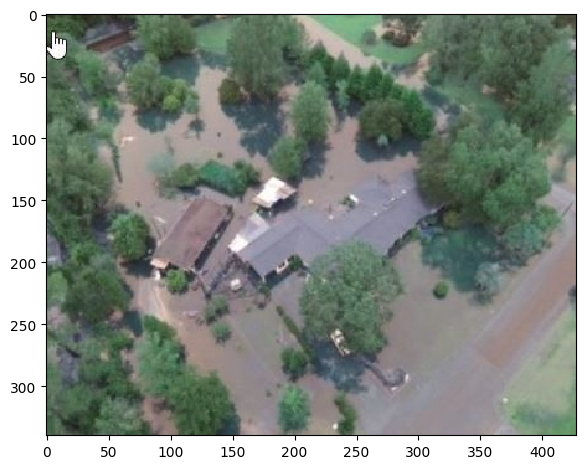

1/20 =======================> In Progress ✔
[84.334962389856, 144.1841204452945]


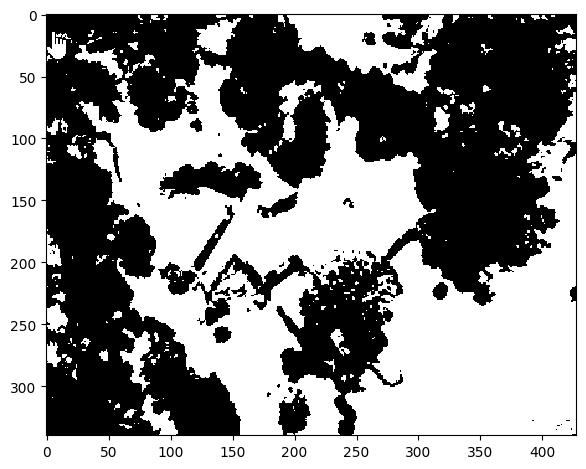

In [77]:
img = io.imread('dataset/flooded/451.jpg')
io.imshow(img)
io.show()

isodata = IsodataClustering(num_clusters=2, max_iterations=20, T=0.9, merge_threshold=10)
model = isodata.fit(img)
print(model.centroids)
io.imshow(model.labels_)
io.show()